In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation


#pd.set_option('display.max_columns', None)

spark = spark = SparkSession \
    .builder \
    .appName("CCproject") \
    .getOrCreate()

# Importing the data 

In [2]:
circuits_schema= StructType([
    StructField("circuitId", IntegerType(), True),
    StructField("circuitRef", StringType(), True),
    StructField("name", StringType(), True),
    StructField("location", StringType(), True),
    StructField("country", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("lng", DoubleType(), True),
    StructField("alt", IntegerType(), True),
    StructField("url", StringType(), True)
])
    
drivers_schema= StructType([
    StructField("driverId", IntegerType(), True),
    StructField("driverRef", StringType(), True),
    StructField("number", IntegerType(), True),
    StructField("code", StringType(), True),
    StructField("forename", StringType(), True),
    StructField("surname", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("nationality", StringType(), True),
    StructField("url", StringType(), True)
])

quali_schema= StructType([
    StructField("qualifyId", IntegerType(), True),
    StructField("raceId", IntegerType(), True),
    StructField("driverId", IntegerType(), True),
    StructField("constructorId", IntegerType(), True),
    StructField("number", IntegerType(), True),
    StructField("position", IntegerType(), True),
    StructField("q1", StringType(), True),
    StructField("q2", StringType(), True),
    StructField("q3", StringType(), True)
])


races_schema= StructType([
    StructField("raceId", IntegerType(), True),
    StructField("year", IntegerType(), True),
    StructField("round", IntegerType(), True),
    StructField("circuitId", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("date", DateType(), True),
    StructField("time", StringType(), True),
    StructField("url", StringType(), True),
    StructField("fp1_date", DateType(), True),
    StructField("fp1_time", StringType(), True),
    StructField("fp2_date", DateType(), True),
    StructField("fp2_time", StringType(), True),
    StructField("fp3_date", DateType(), True),
    StructField("fp3_time", StringType(), True),
    StructField("quali_date", DateType(), True),
    StructField("quali_time", StringType(), True),
    StructField("sprint_date", DateType(), True),
    StructField("sprint_time", StringType(), True)
])

results_schema= StructType([
    StructField("resultId", IntegerType(), True),
    StructField("raceId", IntegerType(), True),
    StructField("driverId", IntegerType(), True),
    StructField("constructorId", IntegerType(), True),
    StructField("number", IntegerType(), True),
    StructField("grid", IntegerType(), True),
    StructField("position", IntegerType(), True),
    StructField("positionText", StringType(), True),
    StructField("positionOrder", IntegerType(), True),
    StructField("points", DoubleType(), True),
    StructField("laps", IntegerType(), True),
    StructField("time", StringType(), True),
    StructField("milliseconds", IntegerType(), True),
    StructField("fastestLap", IntegerType(), True),
    StructField("rank", IntegerType(), True),
    StructField("fastestLapTime", StringType(), True),
    StructField("fastestLapSpeed", StringType(), True),
    StructField("statusId", IntegerType(), True)
])


constructors_schema= StructType([
    StructField("constructorId", IntegerType(), True),
    StructField("constructorRef", StringType(), True),
    StructField("name", StringType(), True),
    StructField("nationality", StringType(), True),
    StructField("url", StringType(), True)
])

In [3]:
circuits= spark.read.csv("hdfs://namenode:8020/f1data/circuits.csv", header=True, schema=circuits_schema)
drivers= spark.read.csv("hdfs://namenode:8020/f1data/drivers.csv", header=True, schema=drivers_schema)
quali= spark.read.csv("hdfs://namenode:8020/f1data/qualifying.csv", header=True, schema=quali_schema)
races= spark.read.csv("hdfs://namenode:8020/f1data/races.csv", header=True, schema=races_schema)
results= spark.read.csv("hdfs://namenode:8020/f1data/results.csv", header=True, schema=results_schema)
constructors= spark.read.csv("hdfs://namenode:8020/f1data/constructors.csv", header=True, schema=constructors_schema)

Showing the columns headings for each data frame:

# EDA

1. Handling Missing Values and Cleaning the data:

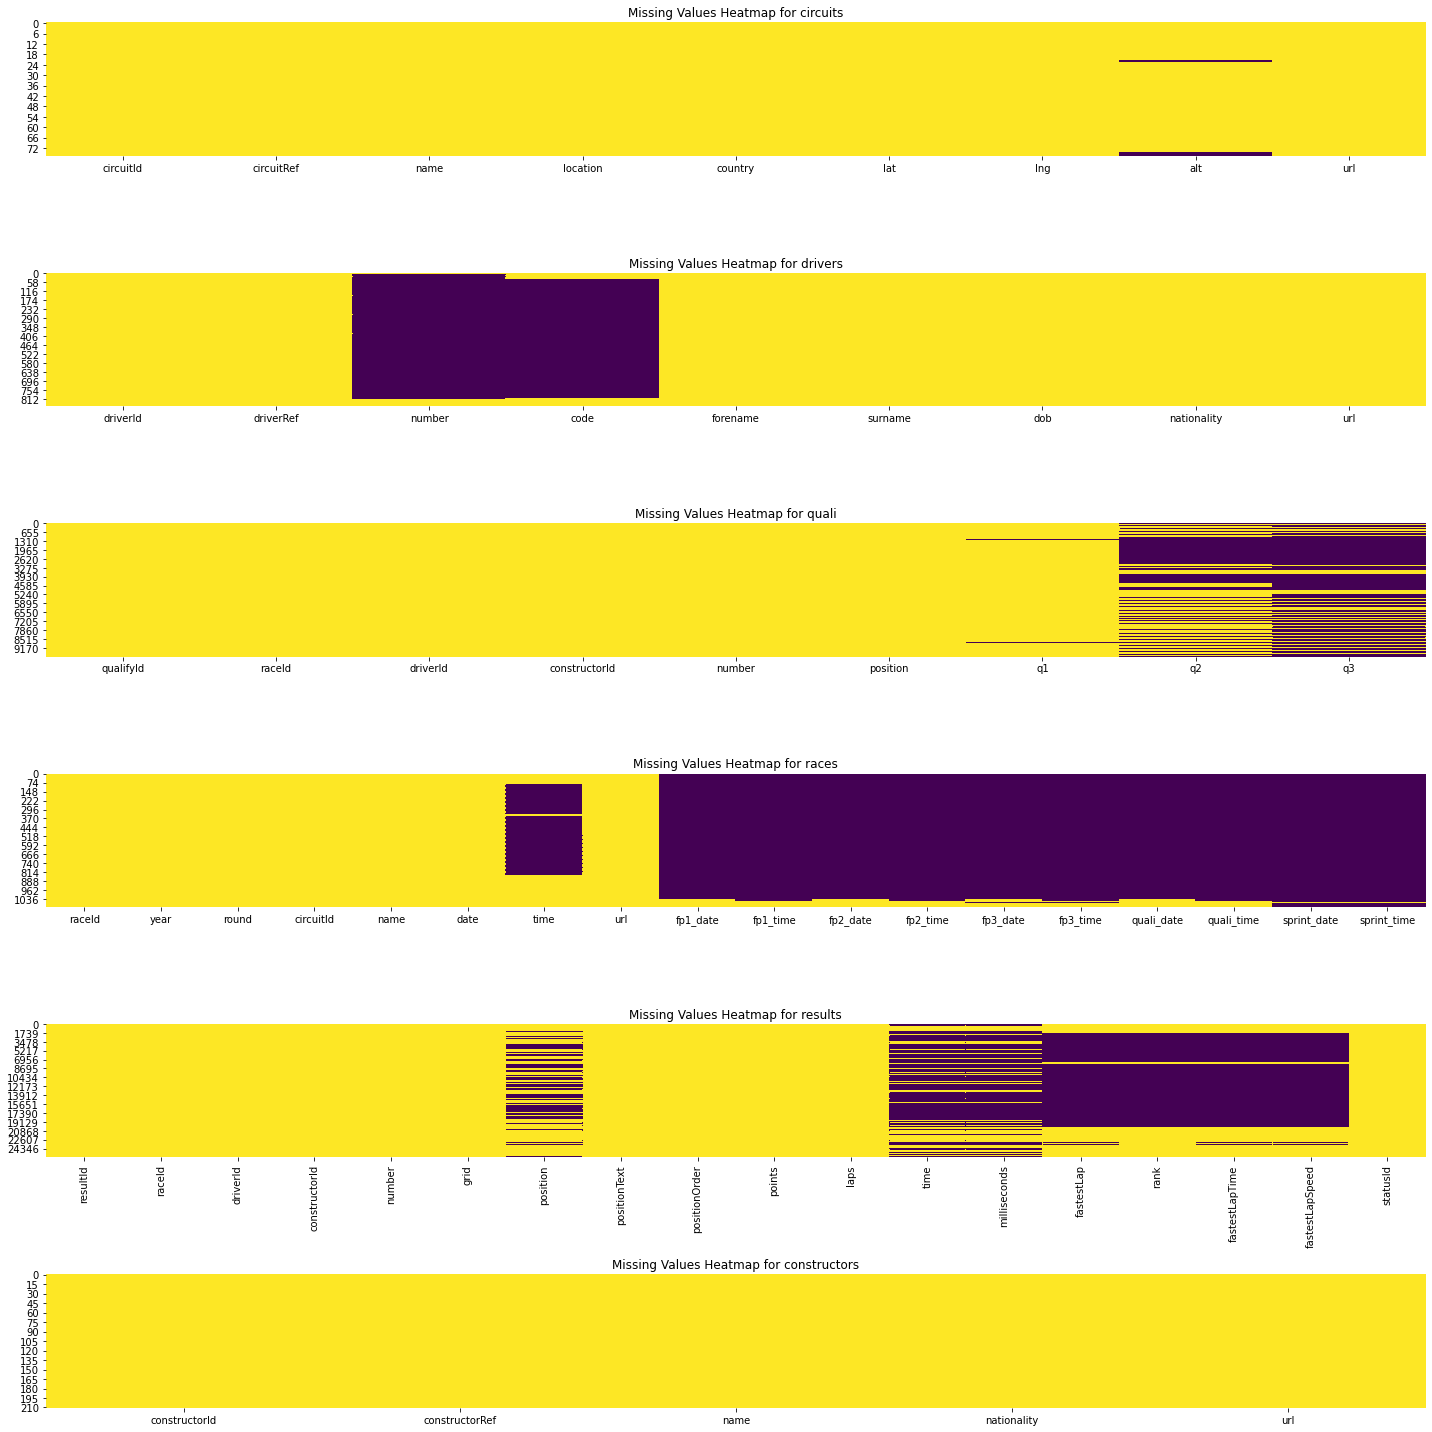

In [4]:
dataframes = [circuits, drivers, quali, races, results, constructors]
dataframe_names = ['circuits', 'drivers', 'quali', 'races', 'results', 'constructors']
fig, axes = plt.subplots(len(dataframes), 1, figsize=(20, 20))

for idx, (df, df_name) in enumerate(zip(dataframes, dataframe_names)):
    
    for column_name in df.columns:
        df = df.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))
    
    missing_values = df.select([col(c).isNull().alias(c) for c in df.columns])
    missing_values_pd = missing_values.toPandas()
    
    sns.heatmap(missing_values_pd, cmap='viridis_r', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'Missing Values Heatmap for {df_name}')

plt.tight_layout()
plt.show()

From the above diagram we can see that the following dataframes have missing values:
circuits, quali, drivers, races and results

Thus let's look at these in further detail:

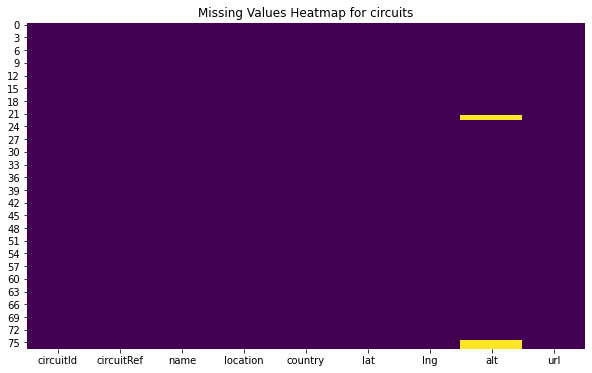

In [5]:
for column_name in circuits.columns:
    circuits = circuits.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))

missing_values_circuits = circuits.select([col(c).isNull().alias(c) for c in circuits.columns])

missing_values_pd_circuits = missing_values_circuits.toPandas()

plt.figure(figsize=(10 ,6))
sns.heatmap(missing_values_pd_circuits, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for circuits')
plt.show()

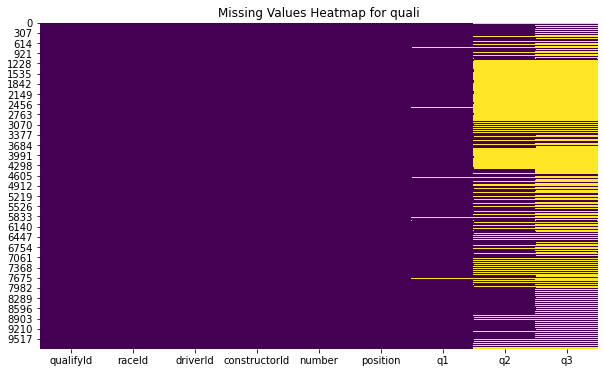

In [6]:
for column_name in quali.columns:
    quali = quali.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))
    
missing_values_quali = quali.select([col(c).isNull().alias(c) for c in quali.columns])

missing_values_pd_quali = missing_values_quali.toPandas()

plt.figure(figsize=(10 ,6))
sns.heatmap(missing_values_pd_quali, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for quali')
plt.show()

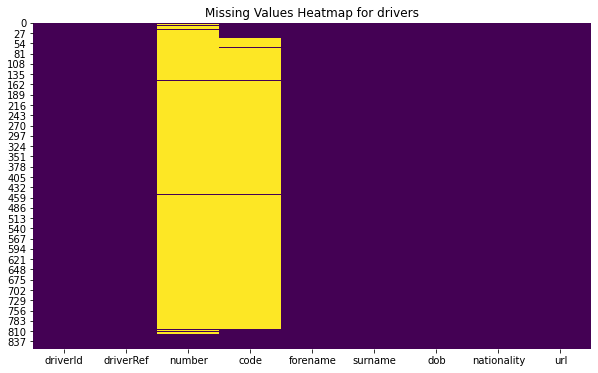

In [7]:
for column_name in drivers.columns:
    drivers = drivers.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))

missing_values_drivers = drivers.select([col(c).isNull().alias(c) for c in drivers.columns])

missing_values_pd_drivers = missing_values_drivers.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_values_pd_drivers, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for drivers')
plt.show()

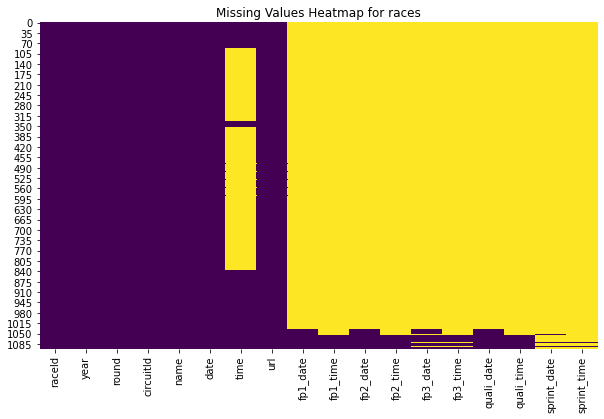

In [8]:
for column_name in races.columns:
    races = races.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))
    
missing_values_races = races.select([col(c).isNull().alias(c) for c in races.columns])

missing_values_pd_races = missing_values_races.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_values_pd_races, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for races')
plt.show()

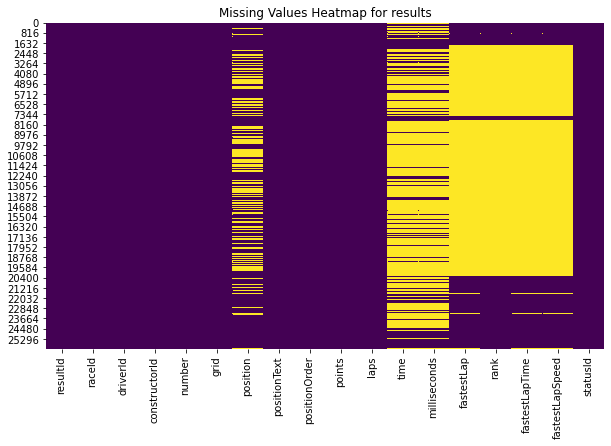

In [9]:
for column_name in results.columns:
    results = results.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))
    
missing_values_results = results.select([col(c).isNull().alias(c) for c in results.columns])

missing_values_pd_results = missing_values_results.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_values_pd_results, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for results')
plt.show()

All the columns containing missing values in the circuits, drivers, races and results data frames are not required for the EDA. Thus, we can delete these columns:

In [10]:
circuits= circuits.drop("alt")
drivers= drivers.drop("number", "code")
races= races.drop("fp1_date","fp1_time", "fp2_date", "fp2_time", "fp3_date", "fp3_time", "quali_date","quali_time", "sprint_date", "sprint_time","time")
results= results.drop("number", "position","time" ,"milliseconds", "fastestLap", "fastestLapTime","fastestLapSpeed", "rank", "status")

In [11]:
results.count()

26080

- Dealing with the missing values in thr quali dataframe:
I want to find the fastest quali time. Let's create a new column that contains the fastest time from q1, q2, q3:

In [12]:
for column_name in quali.columns:
    quali = quali.withColumn(column_name, when(col(column_name) == None, 0).otherwise(col(column_name)))

quali= quali.withColumn("fastest_lap_time", least(quali["q1"], quali["q2"], quali["q3"]))
quali.head()
quali= quali.drop("constructorId")

Now, as there are no missing values remaining, data imputation is not required

2. We can now begin finding the data trends between all the variables in the datasets by feature engineering:

- Firstly, lets look at the results dataset to find which driver has had the most number of wins in F1 since the 1950s:

In [13]:
most_wins= results.drop("positionText", "laps", "statusId")
most_wins= most_wins.join(races, "raceId", "inner")
most_wins= most_wins.drop("round", "date", "url")

most_wins= most_wins.join(drivers, "driverId", "inner")
most_wins= most_wins.withColumn("full_name", concat(col("forename"), lit(" "), col("surname")))
most_wins= most_wins.drop("driverRef", "code", "dob", "url")

In [14]:
most_wins.count()

26080

In [15]:
first_place_results = most_wins.filter(col("positionOrder") == 1)
driver_win_count = first_place_results.groupBy("driverId", "full_name").count()

In [16]:
driver_win_count.head(5)

[Row(driverId=1, full_name='Lewis Hamilton', count=103),
 Row(driverId=219, full_name='Jean-Pierre Jabouille', count=2),
 Row(driverId=238, full_name='Ronnie Peterson', count=10),
 Row(driverId=579, full_name='Juan Fangio', count=24),
 Row(driverId=187, full_name='John Watson', count=5)]

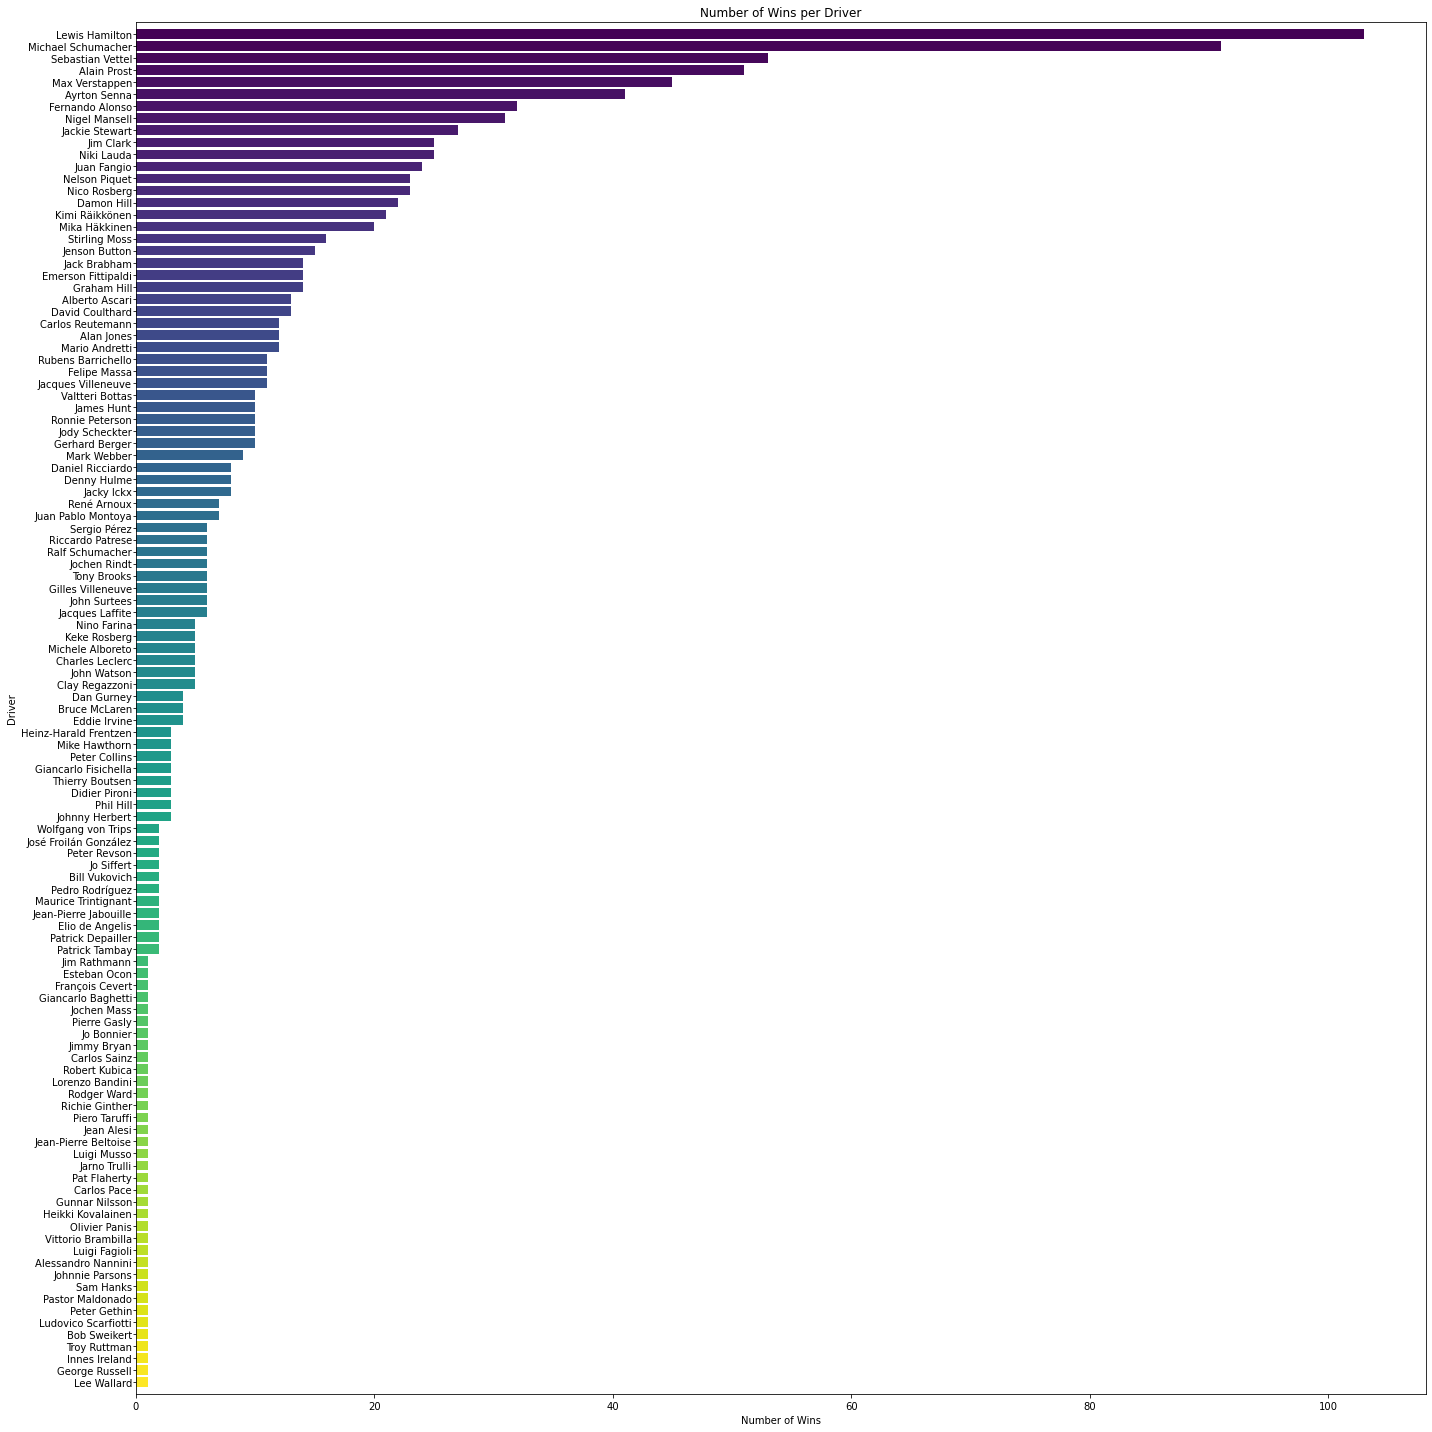

In [17]:
import numpy as np
driver_win_count_pd = driver_win_count.toPandas()
driver_win_count_pd = driver_win_count_pd.sort_values(by="count", ascending=True)

colors = plt.cm.viridis_r(np.linspace(0, 1, len(driver_win_count_pd)))

bar_gap = 0.15
plt.figure(figsize=(20, 20))
plt.barh(driver_win_count_pd["full_name"], driver_win_count_pd["count"], align='center', color=colors)
plt.xlabel("Number of Wins")
plt.ylabel("Driver")
plt.title("Number of Wins per Driver")

plt.tick_params(axis='y', pad=bar_gap)
plt.margins(y=0.005)
plt.tight_layout()

plt.show()

Based on the above plot, we can see that Lewis Hamilton, Michael Schumacher and Sebastian Vettel have won the most number of races.

- Next, lets look at which team has won the constuctor championship each year:

In [18]:
constructors= constructors.drop("nationality")
constructors= constructors.withColumnRenamed('name', 'team_name')
constructor_wins= most_wins.join(constructors, "constructorId", "inner")
constructor_wins= constructor_wins.drop("constructorRef", "url")
constructor_wins.head(5)

[Row(constructorId=1, driverId=1, raceId=18, resultId=1, grid=1, positionOrder=1, points=10.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Lewis', surname='Hamilton', nationality='British', full_name='Lewis Hamilton', team_name='McLaren'),
 Row(constructorId=2, driverId=2, raceId=18, resultId=2, grid=5, positionOrder=2, points=8.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Nick', surname='Heidfeld', nationality='German', full_name='Nick Heidfeld', team_name='BMW Sauber'),
 Row(constructorId=3, driverId=3, raceId=18, resultId=3, grid=7, positionOrder=3, points=6.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Nico', surname='Rosberg', nationality='German', full_name='Nico Rosberg', team_name='Williams'),
 Row(constructorId=4, driverId=4, raceId=18, resultId=4, grid=11, positionOrder=4, points=5.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Fernando', surname='Alonso', nationality='Spanish', full_name='Fern

In [19]:
team_points= constructor_wins.groupBy('year', 'team_name').agg(sum('points').alias('total_points'))

max_points_team= team_points.groupBy('year').agg(max('total_points').alias('max_points'))
max_points_team= max_points_team.withColumnRenamed('year', 'extra_year')

constructors_championship= team_points.join(max_points_team, (team_points['year'] == max_points_team['extra_year']) & (team_points['total_points'] == max_points_team['max_points']))
constructors_championship= constructors_championship.drop("max_points", "extra_year")

#constructors_championship.head(5)

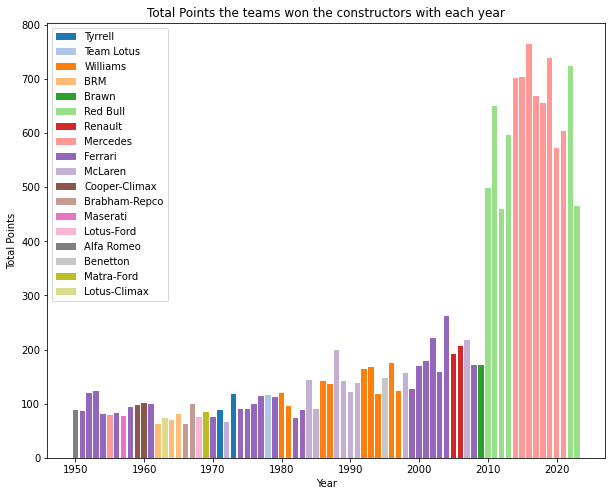

In [20]:
counstructor_count_pd = constructors_championship.toPandas()

team_colors = sns.color_palette("tab20", n_colors=len(counstructor_count_pd['team_name'].unique()))


plt.figure(figsize=(10, 8))
for i, team in enumerate(counstructor_count_pd['team_name'].unique()):
    team_data = counstructor_count_pd[counstructor_count_pd['team_name'] == team]
    plt.bar(team_data['year'], team_data['total_points'], color=team_colors[i], label=team)

plt.xlabel('Year')
plt.ylabel('Total Points')
plt.title('Total Points the teams won the constructors with each year')
plt.legend()

plt.show()

- We can see that the teams have been winning will more number of points after 2010 and the seasons after 2010 have been dominated by RedBull and Mercedes.

Now, lets plot which team has won the constructor the most:

In [21]:
team_mentions= constructors_championship.groupBy("team_name").agg(count("*").alias("Number of constructor_championships"))

In [22]:
team_mentions_pd= team_mentions.toPandas()
team_mentions_pd= team_mentions_pd.sort_values(by="Number of constructor_championships", ascending=True)

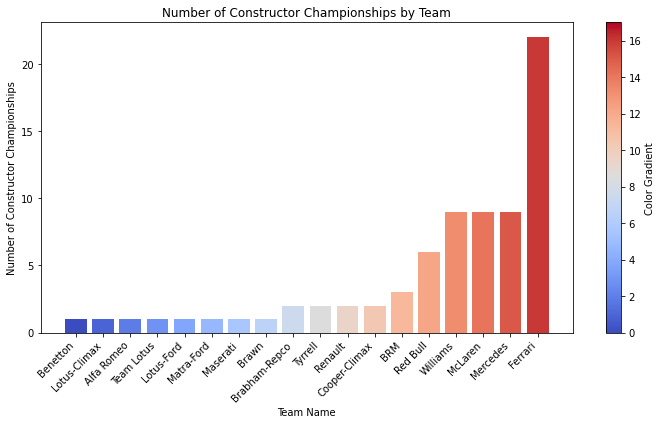

In [23]:
cmap = plt.get_cmap('coolwarm')
plt.figure(figsize=(10, 6))
bars = plt.bar(
    team_mentions_pd["team_name"], team_mentions_pd["Number of constructor_championships"], 
    color=[cmap(i / len(team_mentions_pd["team_name"])) for i in range(len(team_mentions_pd["team_name"]))]
)
#plt.bar(team_mentions_pd["team_name"], team_mentions_pd["Number of constructor_championships"], color='skyblue')
plt.xlabel('Team Name')
plt.ylabel('Number of Constructor Championships')
plt.title('Number of Constructor Championships by Team')
plt.xticks(rotation=45, ha="right")  # Rotate X-axis labels for better visibility
plt.tight_layout()  # Adjust layout for labels

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(team_mentions_pd["team_name"])-1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Color Gradient')
plt.show()

- From the above plot we can see that althought the seasons since 2010 have been dominated by Mercedes and RedBull, Ferrari has won the constructors the most number of times by a large margin. This idicates that Ferrari was a strong team before the 2010 era.

Let's now find which driver has won the driver's the constructor the most and which team were they a part of when they won each one:

In [24]:
driver_points = constructor_wins.groupBy('year','full_name','team_name').agg(sum('points').alias('total_points'))

max_points_driver= driver_points.groupBy('year').agg(max('total_points').alias('max_points'))
max_points_driver= max_points_driver.withColumnRenamed('year', 'extra_year')

drivers_championship= driver_points.join(max_points_driver, (driver_points['year'] == max_points_driver['extra_year']) & (driver_points['total_points'] == max_points_driver['max_points']))
drivers_championship= drivers_championship.drop("max_points", "extra_year")

# driver_mentions= drivers_championship.groupBy("full_name").agg(count("*").alias("Number of driver_championships"))

championships_per_team = drivers_championship.groupBy("full_name", "team_name").agg(count("*").alias("driver_championships"))

#championships_per_team.head(5)

<Figure size 720x432 with 0 Axes>

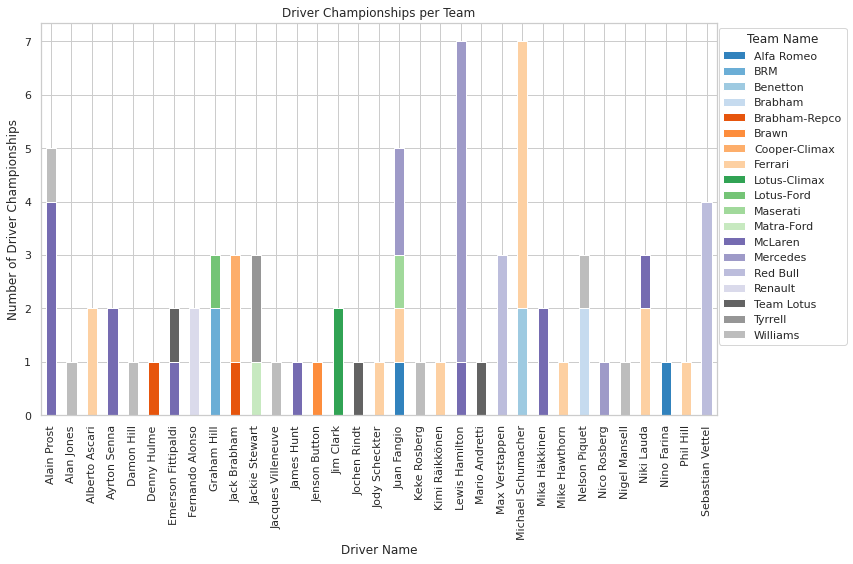

In [25]:
driver_championships_pd= championships_per_team.toPandas()
pivot_df = driver_championships_pd.pivot(index='full_name', columns='team_name', values='driver_championships').fillna(0)

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
palette = sns.color_palette("tab20c", n_colors=len(pivot_df.columns))

pivot_df.plot(kind='bar', stacked=True, color=palette, figsize=(12, 8))
plt.ylabel('Number of Driver Championships')
plt.xlabel('Driver Name')
plt.title('Driver Championships per Team')
plt.legend(title='Team Name', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

- From the above plot we can understand the demoinance that Ferrari had in the years before 2010. Michael Schumacher ties with Lewis Hamilton to be 7 time world chamionships. Schumacher won most of his world championships with Ferrari while Hamilton won most of his titles with Mercedes.

Next, let's use machine learning classifiers to create a model that can predict if a driver will finish in the points of not, depending on the number of times they have won races and number of times their team has won races.

# ML classifier and models:

In [26]:
driver_win_count.createOrReplaceTempView("driver_wins")
constructor_wins.createOrReplaceTempView("constructor_wins")

# Perform a SQL join and aggregation
result_df = spark.sql("""
    SELECT c.*,
           d.count AS driver_wins_count
    FROM constructor_wins c
    JOIN driver_wins d ON c.driverId = d.driverId
""")

# Show the resulting DataFrame
#result_df.head(5)

In [27]:
# Group by constructorId and count the number of times positionOrder is 1
team_races_won_df = result_df.groupBy("constructorId").agg(
    sum(when(col("positionOrder") == 1, 1).otherwise(0)).alias("team_races_won")
)
#team_races_won_df.head(5)

In [28]:
# Join this new DataFrame with the original result_df
result_df = result_df.join(team_races_won_df, on="constructorId", how="left")

result_df= result_df.withColumn("Classifier", F.when(result_df["points"] > 0, 1)
                                     .otherwise(0))
# Show the DataFrame with the new column
#result_df.head(5)

In the above code we create a classifier column that segregates the points column into a binary classifier, 1 if the driver has scored any points and 0 if the driver didn't score any points.

In [29]:
result_df.head(5)

[Row(constructorId=65, driverId=163, raceId=529, resultId=12861, grid=0, positionOrder=27, points=0.0, year=1978, circuitId=30, name='South African Grand Prix', forename='René', surname='Arnoux', nationality='French', full_name='René Arnoux', team_name='Martini', driver_wins_count=7, team_races_won=0, Classifier=0),
 Row(constructorId=65, driverId=163, raceId=531, resultId=12921, grid=0, positionOrder=27, points=0.0, year=1978, circuitId=6, name='Monaco Grand Prix', forename='René', surname='Arnoux', nationality='French', full_name='René Arnoux', team_name='Martini', driver_wins_count=7, team_races_won=0, Classifier=0),
 Row(constructorId=65, driverId=163, raceId=532, resultId=12933, grid=19, positionOrder=9, points=0.0, year=1978, circuitId=40, name='Belgian Grand Prix', forename='René', surname='Arnoux', nationality='French', full_name='René Arnoux', team_name='Martini', driver_wins_count=7, team_races_won=0, Classifier=0),
 Row(constructorId=65, driverId=163, raceId=535, resultId=13

In [30]:
from scipy import stats
pandas1 = result_df.select("driver_wins_count", 'Classifier').toPandas()

crosstab = pd.crosstab(pandas1["driver_wins_count"], pandas1['Classifier'])
chi2, p, _, _ = stats.chi2_contingency(crosstab)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

Chi-squared statistic: 1033.6760642385434
P-value: 3.967812649545511e-198


In [31]:
pandas2 = result_df.select("team_races_won", 'Classifier').toPandas()

crosstab = pd.crosstab(pandas2["team_races_won"], pandas2['Classifier'])
chi2, p, _, _ = stats.chi2_contingency(crosstab)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

Chi-squared statistic: 1573.5531055868173
P-value: 0.0


- As we can see both variables, driver_wins count and team_races_won have a significant affect on whether a driver ends up in the points or not.

In [32]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


feature_columns = ["driver_wins_count", "team_races_won"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(result_df)


data = data.withColumn("label", data["Classifier"])


(training_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)


lr = LogisticRegression(featuresCol="features", labelCol="label")


model = lr.fit(training_data)

#predictions.head(5)

In [33]:
predictions = model.transform(test_data)


accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Classifier", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy: ", accuracy)


f1_evaluator = MulticlassClassificationEvaluator(labelCol="Classifier", predictionCol="prediction", metricName="f1")
f1= f1_evaluator.evaluate(predictions)
print("f1 score: ", f1)


evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions)
print("AUC: ", auc)

Accuracy:  0.6343692870201096
f1 score:  0.6274955085966657
AUC:  0.6868348462267984


- The logistic regression classifier does not do a good job in generalizing the model but, lets the how different the predicitons are from the test data values:

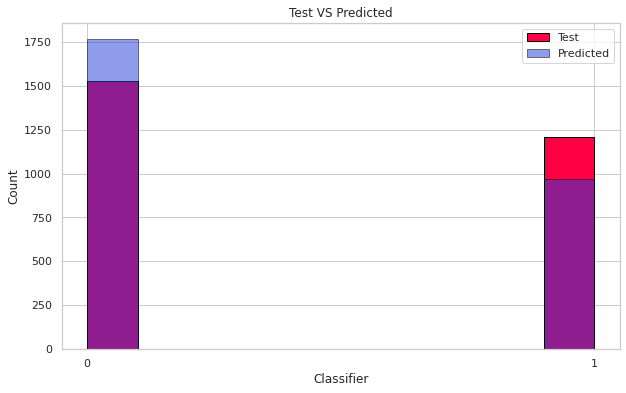

In [34]:
predictions_pd = model.transform(test_data).toPandas()
plt.figure(figsize = (10,6))
plt.hist(test_data.toPandas()["Classifier"], edgecolor = "#000000", color = "#ff0044")
plt.hist(predictions_pd["prediction"], edgecolor = "#000000", color = "#213adb" , alpha = 0.5)
plt.legend(["Test", "Predicted"])
custom_ticksx = [0,1]
plt.xticks(custom_ticksx)
plt.ylabel("Count")
plt.xlabel("Classifier")
plt.title("Test VS Predicted")
plt.show()

- As we can see the Logistic Regression classifier does not do such a good job on the test data, thus lets try using the Random Forest classifier to improve the model:

In [35]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(labelCol="Classifier", featuresCol="features")
modelrf = rf.fit(training_data)

In [36]:
predictionsrf = modelrf.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="Classifier")
auc = evaluator.evaluate(predictionsrf)
print("AUC:", auc)

AUC: 0.7115442351984824


In [37]:
evaluator = MulticlassClassificationEvaluator(labelCol="Classifier", predictionCol="prediction", metricName="accuracy")
accuracyrf = evaluator.evaluate(predictionsrf)

f1_evaluatorrf = MulticlassClassificationEvaluator(labelCol="Classifier", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluatorrf.evaluate(predictionsrf)

print("Accuracy:", accuracyrf)
print("F1 Score:", f1_score)

Accuracy: 0.6595978062157222
F1 Score: 0.6603924935560915


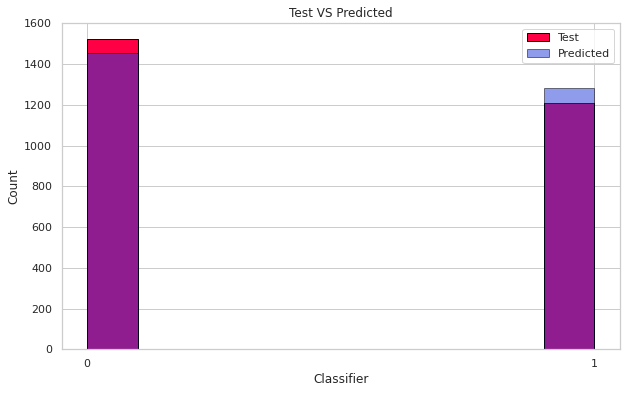

In [38]:
predictions_pd_rf = modelrf.transform(test_data).toPandas()
plt.figure(figsize = (10,6))
plt.hist(test_data.toPandas()["Classifier"], edgecolor = "#000000", color = "#ff0044")
plt.hist(predictions_pd_rf["prediction"], edgecolor = "#000000", color = "#213adb" , alpha = 0.5)
plt.legend(["Test", "Predicted"])
custom_ticksx = [0,1]
plt.xticks(custom_ticksx)
plt.ylabel("Count")
plt.xlabel("Classifier")
plt.title("Test VS Predicted")
plt.show()

- From the above plot we can see that the Random Forest Classifier does a better job than the Logistic Regression classifier, but the model is still not generlized well as the accuracy and F1 score are pretty low.

Based on the analysis above, we can see that a drivers win in a grand prix can be heavily influenced by the team they are in. Thus, let's look at the dependence of sevral other attributes more closely and create a machine learning model that is able to predict whether a driver will win a race or not for the 2024 race season:

- Lets look at the correlations between the starting grid position, race results, circuit and whether the driver wins the race or not:

In [39]:
winsornot_df= constructor_wins

winsornot_df= winsornot_df.withColumn("Classifier", F.when(winsornot_df["positionOrder"] == 1, "P1")
                                     .otherwise("Didn't Win"))
winsornot_df.head(5)

[Row(constructorId=1, driverId=1, raceId=18, resultId=1, grid=1, positionOrder=1, points=10.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Lewis', surname='Hamilton', nationality='British', full_name='Lewis Hamilton', team_name='McLaren', Classifier='P1'),
 Row(constructorId=2, driverId=2, raceId=18, resultId=2, grid=5, positionOrder=2, points=8.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Nick', surname='Heidfeld', nationality='German', full_name='Nick Heidfeld', team_name='BMW Sauber', Classifier="Didn't Win"),
 Row(constructorId=3, driverId=3, raceId=18, resultId=3, grid=7, positionOrder=3, points=6.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Nico', surname='Rosberg', nationality='German', full_name='Nico Rosberg', team_name='Williams', Classifier="Didn't Win"),
 Row(constructorId=4, driverId=4, raceId=18, resultId=4, grid=11, positionOrder=4, points=5.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='

In [40]:
# pip install scipy

In [41]:
from scipy import stats

pandas_df = winsornot_df.select("constructorId", 'Classifier').toPandas()

# Perform a chi-squared test
crosstab = pd.crosstab(pandas_df['constructorId'], pandas_df['Classifier'])
chi2, p, _, _ = stats.chi2_contingency(crosstab)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

Chi-squared statistic: 1622.1232665181242
P-value: 7.996970076237836e-217


In [42]:
pandas_df2 = winsornot_df.select("grid", 'Classifier').toPandas()

# Perform a chi-squared test
crosstab = pd.crosstab(pandas_df2['grid'], pandas_df2['Classifier'])
chi2, p, _, _ = stats.chi2_contingency(crosstab)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

Chi-squared statistic: 5866.175079053852
P-value: 0.0


In [43]:
pandas_df4 = winsornot_df.select("circuitId", 'Classifier').toPandas()

# Perform a chi-squared test
crosstab = pd.crosstab(pandas_df4['circuitId'], pandas_df4['Classifier'])
chi2, p, _, _ = stats.chi2_contingency(crosstab)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

Chi-squared statistic: 10.798950623748228
P-value: 1.0


- We can see that both starting grid position and the team the driver is racing in have a significant effect on the driver winning or not, but the circuit the driver is driving in seems to have no effect. Thus, lets use the grid position and team name to create a knn classification model that will predict the race outcome for a driver:

In [44]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

teams_to_include = [
    'Williams', 'Alfa Romeo', 'Red Bull', 'Mercedes', 'Haas F1 Team', 'Ferrari',
    'McLaren', 'Aston Martin', 'Racing Point', 'Torro Rosso', 'Renault', 'Alpine F1 Team', 'AlphaTauri'
]

# Filter the DataFrame
winsornot_fildf = winsornot_df.filter(winsornot_df["team_name"].isin(teams_to_include))

winsornot_fildf = winsornot_fildf.withColumn("team_name", when(winsornot_fildf["team_name"] == "Torro Rosso", "AlphaTauri").otherwise(winsornot_fildf["team_name"]))
winsornot_fildf = winsornot_fildf.withColumn("team_name", when(winsornot_fildf["team_name"] == "Racing Point", "Aston Martin").otherwise(winsornot_fildf["team_name"]))
winsornot_fildf = winsornot_fildf.withColumn("team_name", when(winsornot_fildf["team_name"] == "Renault", "Alpine F1 Team").otherwise(winsornot_fildf["team_name"]))

winsornot_fildf= winsornot_fildf.withColumn(
    "Classifier",
    when(col("Classifier") == "P1", 1)
    .otherwise(0)
)

winsornot_fildf= winsornot_fildf.filter((col("grid") > 0) & (col("grid") <= 20))

#winsornot_fildf.head(5)

- In the above snippet of code, the dataframe is filtered to onlly contain the teams that will be participating the 2024 F1 season.

In [45]:
winsornot_df_pd= winsornot_fildf.toPandas()
#winsornot_df_pd.head()

In [46]:
winsornot_df_pd.shape[0]

8862

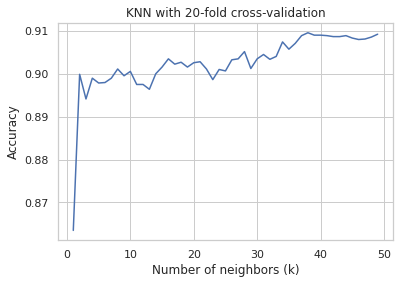

Optimal number of neighbors (k): 38
Highest accuracy: 0.9096137616171476


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder


# Separate features and target variable
label_encoder = LabelEncoder()
winsornot_df_pd['constructor_encoded'] = label_encoder.fit_transform(winsornot_df_pd['team_name'])

X = winsornot_df_pd[['grid','constructor_encoded']]
y = winsornot_df_pd['Classifier']


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

k_values = range(1, 50)  # Range of k values to test
accuracy_scores = []  # List to store accuracy scores

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=20, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

# Plot the accuracy scores for different k values
plt.plot(k_values, accuracy_scores)
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN with 20-fold cross-validation')
plt.show()

best_k = k_values[np.argmax(accuracy_scores)]
print('Optimal number of neighbors (k):', best_k)
print('Highest accuracy:', np.max(accuracy_scores))


In [48]:
knn = KNeighborsClassifier(n_neighbors=best_k)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.89


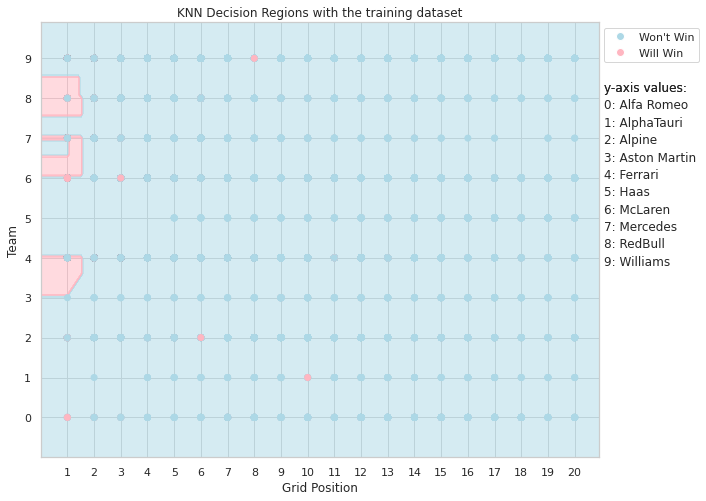

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# Generate a meshgrid of points to plot the decision regions
x_min, x_max = X.iloc[:,0].min() - 1, X.iloc[:,0].max() + 1
y_min, y_max = X.iloc[:,1].min() - 1, X.iloc[:,1].max() + 1
h = 0.1  # increased step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions on the meshgrid points
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Encode the string labels into numeric values
label_encoder = LabelEncoder()
Z = label_encoder.fit_transform(Z)

# Reshape the array and convert to float
Z = Z.reshape(xx.shape).astype(float)

# Create a colormap for the classes
cmap = ListedColormap(['lightblue', 'lightpink'])

# Encode the training labels into numeric values
y_train_encoded = label_encoder.transform(y_train)

# Plot the decision regions
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)


plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train_encoded, cmap=cmap)

custom_ticksx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
custom_ticksy = [0,1,2,3,4,5,6,7,8,9]
plt.xticks(custom_ticksx)
plt.yticks(custom_ticksy)
plt.xlabel('Grid Position')
plt.ylabel('Team')
plt.title('KNN Decision Regions with the training dataset')

# Create a legend
class_names = ["Won't Win", 'Will Win']
class_markers = ['o', 'o']
handles = [plt.Line2D([], [], marker=marker, color='w', label=name, markerfacecolor=color, markersize=8)
           for name, color, marker in zip(class_names, cmap.colors, class_markers)]
plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.19, 1))

y_legend_text = 'y-axis values:'
plt.text(1.01, 0.85, y_legend_text, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')

team1 = '0: Alfa Romeo'
team2 = '1: AlphaTauri'
team3 = '2: Alpine'
team4 = '3: Aston Martin'
team5 = '4: Ferrari'
team6 = '5: Haas'
team7 = '6: McLaren'
team8 = '7: Mercedes'
team9 = '8: RedBull'
team10 = '9: Williams'

plt.text(1.01, 0.85, y_legend_text, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.81, team1, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.77, team2, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.73, team3, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.69, team4, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.65, team5, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.61, team6, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.57, team7, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.53, team8, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.49, team9, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.45, team10, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')


plt.show()

- The above model predicts that if the driver starts from P1 and are part of Aston Martin, Ferrari, Mclaren, Mercedes or Redbull they will win the race.